# Unified Image & Video Clustering

This notebook demonstrates **interoperable clustering** of images and videos using the same CLIP embedding space.

**Key Points:**
- Both images and videos use `clip-ViT-B-32` → 512-dimensional embeddings
- Embeddings are normalized (`normalize_embeddings=True`) → cosine similarity works across media types
- Videos are represented by aggregated frame embeddings (mean + attention pooling)
- Images are represented by direct CLIP embeddings
- **Result:** Images and videos can be clustered together seamlessly

This enables a unified `/api/v1/search` endpoint that returns both images and videos ranked by semantic similarity.


In [1]:
%pip install --quiet sentence-transformers pillow matplotlib scikit-learn numpy opencv-python-headless google-generativeai python-dotenv requests



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import collections
import io
import json
import math
import os
import time
from collections import defaultdict
from dataclasses import dataclass
from enum import Enum
from pathlib import Path
from typing import Dict, List, Sequence, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

DEVICE = "cpu"
CLUSTER_SIMILARITY_THRESHOLD = 0.82
TARGET_ITEMS_PER_CLUSTER = 40
MIN_CLUSTER_SIZE_RATIO = 0.05


class MediaType(str, Enum):
    IMAGE = "image"
    VIDEO = "video"


@dataclass
class MediaSample:
    media_type: MediaType
    path: Path
    embedding: torch.Tensor
    # For images: the image itself
    image: Image.Image | None = None
    # For videos: list of frames
    frames: List[Image.Image] | None = None
    frame_weights: List[float] | None = None

    def get_thumbnail(self) -> Image.Image:
        """Get a representative thumbnail for visualization."""
        if self.media_type == MediaType.IMAGE and self.image:
            return self.image
        if self.media_type == MediaType.VIDEO and self.frames:
            if self.frame_weights:
                top_idx = max(range(len(self.frames)), key=lambda i: self.frame_weights[i])
                return self.frames[top_idx]
            return self.frames[0]
        raise ValueError(f"No thumbnail available for {self.path}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Initialize CLIP model (shared for both images and videos)
model = SentenceTransformer("clip-ViT-B-32", device=DEVICE)
model.eval()
print("✓ CLIP model ready (clip-ViT-B-32) - Shared for images and videos")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ CLIP model ready (clip-ViT-B-32) - Shared for images and videos


In [4]:
# Helper functions from both notebooks (simplified for unified use)

IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".gif", ".bmp"}
VIDEO_EXTENSIONS = {".mp4", ".mov", ".avi", ".mkv", ".webm"}
MAX_FRAMES_PER_VIDEO = 12
FRAME_RESIZE = (224, 224)


def load_images(image_root: Path) -> List[MediaSample]:
    """Load images and generate embeddings."""
    samples: List[MediaSample] = []
    for path in sorted(image_root.rglob("*")):
        if path.suffix.lower() not in IMAGE_EXTENSIONS:
            continue
        try:
            img = Image.open(path).convert("RGB")
            embedding = model.encode(
                img,
                convert_to_tensor=True,
                device=DEVICE,
                normalize_embeddings=True,
            )
            samples.append(MediaSample(
                media_type=MediaType.IMAGE,
                path=path,
                embedding=embedding,
                image=img,
            ))
        except Exception:
            continue
    return samples


def extract_frames_from_video(video_path: Path, max_frames: int = MAX_FRAMES_PER_VIDEO) -> List[Image.Image]:
    """Extract representative frames from video."""
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        return []
    
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        cap.release()
        return []
    
    frame_interval = max(int(fps * 0.5), 1)
    candidate_indices = np.linspace(0, total_frames - 1, num=min(max_frames * 2, total_frames), dtype=int)
    
    frames: List[Image.Image] = []
    last_idx = -frame_interval
    for idx in candidate_indices:
        if idx - last_idx < frame_interval:
            continue
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))
        success, frame = cap.read()
        if success:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb).resize(FRAME_RESIZE, Image.Resampling.BICUBIC)
            frames.append(pil_image)
            last_idx = idx
        if len(frames) >= max_frames:
            break
    
    cap.release()
    return frames if frames else []


def compute_video_embedding(frames: List[Image.Image], clip_model: SentenceTransformer) -> Tuple[torch.Tensor, List[float]]:
    """Compute video embedding from frames (same approach as video notebook)."""
    if not frames:
        raise ValueError("No frames provided")
    
    frame_embeddings = clip_model.encode(
        frames,
        batch_size=min(len(frames), 8),
        convert_to_tensor=True,
        device=DEVICE,
        normalize_embeddings=True,
    )
    if frame_embeddings.ndim == 1:
        frame_embeddings = frame_embeddings.unsqueeze(0)
    
    # Attention-weighted pooling (same as video notebook)
    mean_embedding = frame_embeddings.mean(dim=0)
    temperature = 0.08
    attention_scores = torch.matmul(frame_embeddings, mean_embedding.unsqueeze(1)).squeeze(1) / temperature
    attention_weights = torch.softmax(attention_scores, dim=0)
    weighted_embedding = torch.sum(frame_embeddings * attention_weights.unsqueeze(1), dim=0)
    combined_embedding = 0.6 * mean_embedding + 0.4 * weighted_embedding
    normalized_embedding = F.normalize(combined_embedding.unsqueeze(0), dim=1).squeeze(0)
    
    return normalized_embedding, attention_weights.detach().cpu().tolist()


def load_videos(video_root: Path) -> List[MediaSample]:
    """Load videos and generate embeddings."""
    samples: List[MediaSample] = []
    for path in sorted(video_root.rglob("*")):
        if path.suffix.lower() not in VIDEO_EXTENSIONS:
            continue
        frames = extract_frames_from_video(path)
        if not frames:
            continue
        try:
            embedding, weights = compute_video_embedding(frames, model)
            samples.append(MediaSample(
                media_type=MediaType.VIDEO,
                path=path,
                embedding=embedding,
                frames=frames,
                frame_weights=weights,
            ))
        except Exception:
            continue
    return samples


In [5]:
# Load both images and videos
def resolve_media_roots() -> Tuple[Path | None, Path | None]:
    """Resolve image and video directories."""
    cwd = Path(os.getcwd()).resolve()
    image_candidates = [
        cwd / "images",
        cwd / "notebooks" / "images",
        cwd.parent / "notebooks" / "images",
    ]
    video_candidates = [
        cwd / "videos",
        cwd / "notebooks" / "videos",
        cwd.parent / "notebooks" / "videos",
    ]
    
    image_root = next((c for c in image_candidates if c.exists() and c.is_dir()), None)
    video_root = next((c for c in video_candidates if c.exists() and c.is_dir()), None)
    
    return image_root, video_root


image_root, video_root = resolve_media_roots()

all_samples: List[MediaSample] = []

if image_root:
    image_samples = load_images(image_root)
    all_samples.extend(image_samples)
    print(f"✓ Loaded {len(image_samples)} images from {image_root}")

if video_root:
    video_samples = load_videos(video_root)
    all_samples.extend(video_samples)
    print(f"✓ Loaded {len(video_samples)} videos from {video_root}")

if not all_samples:
    raise RuntimeError("No images or videos found. Add media to ./images or ./notebooks/videos")

print(f"\n📊 Total media items: {len(all_samples)}")
print(f"   Images: {sum(1 for s in all_samples if s.media_type == MediaType.IMAGE)}")
print(f"   Videos: {sum(1 for s in all_samples if s.media_type == MediaType.VIDEO)}")

# Verify embedding compatibility
embeddings = torch.stack([s.embedding for s in all_samples])
print(f"\n✓ All embeddings shape: {embeddings.shape} (all {embeddings.shape[1]}-dimensional)")
print(f"  Embedding norms (should be ~1.0): min={embeddings.norm(dim=1).min():.4f}, max={embeddings.norm(dim=1).max():.4f}")


✓ Loaded 3012 images from /Users/aban/drive/Projects/Automated-File-Allocator/notebooks/images
✓ Loaded 5 videos from /Users/aban/drive/Projects/Automated-File-Allocator/notebooks/videos

📊 Total media items: 3017
   Images: 3012
   Videos: 5

✓ All embeddings shape: torch.Size([3017, 512]) (all 512-dimensional)
  Embedding norms (should be ~1.0): min=1.0000, max=1.0000


In [6]:
def cluster_unified_media(
    embeddings: torch.Tensor,
    samples: Sequence[MediaSample],
    similarity_threshold: float = CLUSTER_SIMILARITY_THRESHOLD,
    target_items_per_cluster: int = TARGET_ITEMS_PER_CLUSTER,
    min_cluster_ratio: float = MIN_CLUSTER_SIZE_RATIO,
) -> Tuple[Dict[int, List[int]], np.ndarray]:
    """Cluster images and videos together using cosine similarity."""
    num_items = len(samples)
    if num_items == 0:
        return {}, np.array([], dtype=np.int32)
    
    desired_clusters = max(1, min(num_items, int(np.ceil(num_items / target_items_per_cluster))))
    min_cluster_size = max(1, int(num_items * min_cluster_ratio))
    
    print(f"Target clusters: {desired_clusters} | Minimum cluster size: {min_cluster_size}")
    
    embeddings_np = embeddings.cpu().numpy()
    distance_threshold = max(1.0 - similarity_threshold, 1e-3)
    
    clustering_start = time.perf_counter()
    try:
        agglo = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=distance_threshold,
            metric="cosine",
            linkage="average",
            compute_full_tree=True,
        )
        initial_labels = agglo.fit_predict(embeddings_np)
    except TypeError:
        agglo = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=distance_threshold,
            affinity="cosine",
            linkage="average",
            compute_full_tree=True,
        )
        initial_labels = agglo.fit_predict(embeddings_np)
    
    unique_labels = np.unique(initial_labels)
    if len(unique_labels) < desired_clusters and desired_clusters > 1:
        fallback = AgglomerativeClustering(
            n_clusters=desired_clusters,
            metric="cosine",
            linkage="average",
        )
        initial_labels = fallback.fit_predict(embeddings_np)
    
    clustering_duration = time.perf_counter() - clustering_start
    
    clusters: Dict[int, List[int]] = collections.defaultdict(list)
    for index, label in enumerate(initial_labels):
        clusters[int(label)].append(index)
    
    # Merge tiny clusters
    if min_cluster_size > 1:
        centroids = {
            cid: F.normalize(embeddings[indices].mean(dim=0, keepdim=True), dim=1).squeeze(0)
            for cid, indices in clusters.items()
        }
        small_clusters = [cid for cid, indices in clusters.items() if len(indices) < min_cluster_size]
        
        for cid in small_clusters:
            if cid not in clusters:
                continue
            similarities: Dict[int, float] = {}
            for other_cid, centroid in centroids.items():
                if other_cid == cid or other_cid not in clusters:
                    continue
                similarity = torch.dot(centroids[cid], centroid).item()
                similarities[other_cid] = similarity
            if not similarities:
                continue
            best_target = max(similarities, key=similarities.get)
            clusters[best_target].extend(clusters[cid])
            merged_indices = clusters[best_target]
            centroids[best_target] = F.normalize(
                embeddings[merged_indices].mean(dim=0, keepdim=True),
                dim=1,
            ).squeeze(0)
            del clusters[cid]
            centroids.pop(cid, None)
    
    reindexed_clusters: Dict[int, List[int]] = collections.defaultdict(list)
    cluster_assignments = np.full(num_items, -1, dtype=np.int32)
    for new_id, (cid, indices) in enumerate(sorted(clusters.items())):
        for idx in indices:
            reindexed_clusters[new_id].append(idx)
            cluster_assignments[idx] = new_id
    
    print(f"\n✓ Clustered {num_items} items into {len(reindexed_clusters)} clusters ({clustering_duration:.2f}s)")
    
    # Show media type distribution per cluster
    for cluster_id, indices in sorted(reindexed_clusters.items()):
        images_in_cluster = sum(1 for idx in indices if samples[idx].media_type == MediaType.IMAGE)
        videos_in_cluster = sum(1 for idx in indices if samples[idx].media_type == MediaType.VIDEO)
        print(f"  Cluster {cluster_id}: {len(indices)} items ({images_in_cluster} images, {videos_in_cluster} videos)")
    
    return reindexed_clusters, cluster_assignments


# Perform unified clustering
unified_clusters, unified_assignments = cluster_unified_media(embeddings, all_samples)


Target clusters: 76 | Minimum cluster size: 150

✓ Clustered 3017 items into 3 clusters (2.77s)
  Cluster 0: 300 items (300 images, 0 videos)
  Cluster 1: 484 items (479 images, 5 videos)
  Cluster 2: 2233 items (2233 images, 0 videos)


/var/folders/6k/cwckznk13xq5wtrxb843cfhm0000gn/T/ipykernel_41285/934189289.py:41: UserWarning: Glyph 128247 (\N{CAMERA}) missing from current font.
  plt.tight_layout()
/var/folders/6k/cwckznk13xq5wtrxb843cfhm0000gn/T/ipykernel_41285/934189289.py:41: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  plt.tight_layout()
/Users/aban/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128247 (\N{CAMERA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aban/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


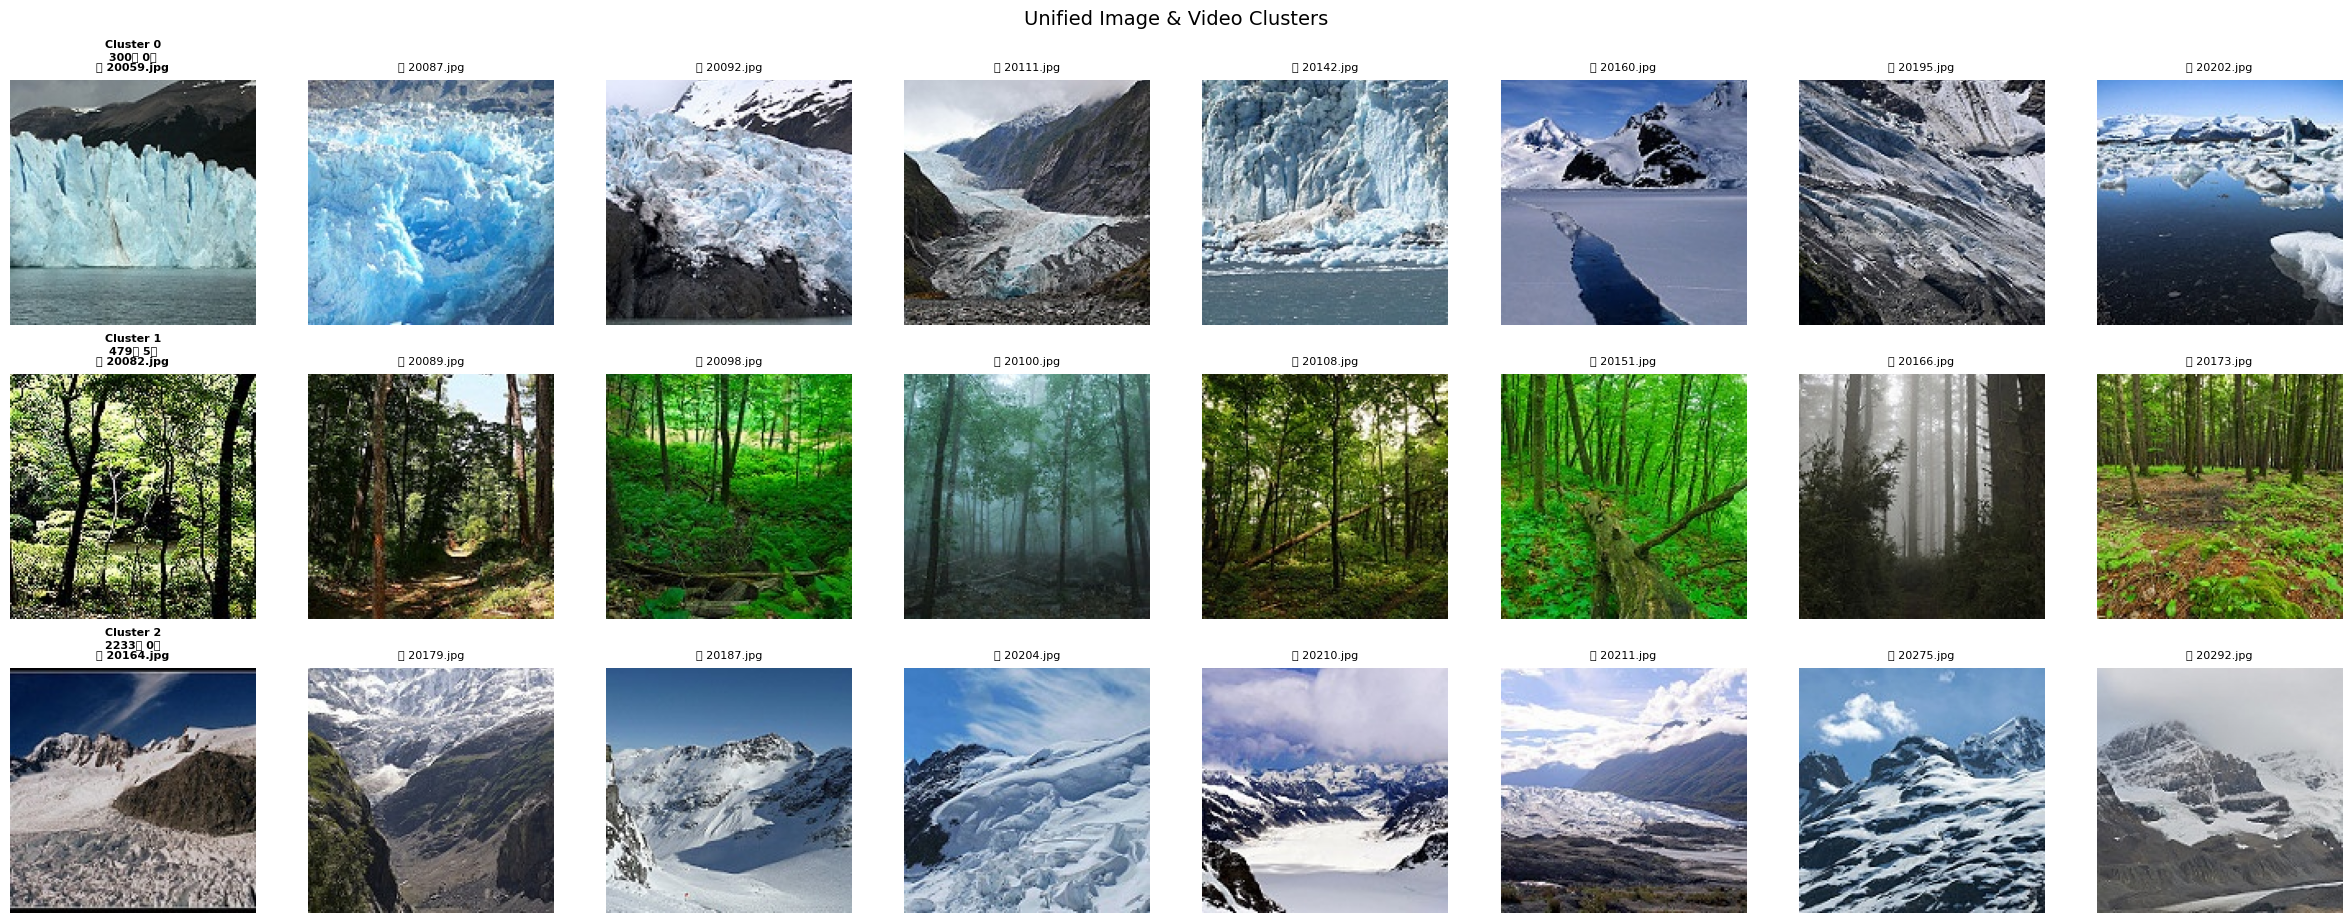

In [7]:
def visualize_unified_clusters(
    clusters: Dict[int, List[int]],
    samples: Sequence[MediaSample],
    max_items_per_cluster: int = 8,
) -> None:
    """Visualize clusters showing both images and videos."""
    if not clusters:
        print("No clusters to visualize")
        return
    
    rows = len(clusters)
    cols = max(1, min(max_items_per_cluster, max(len(idxs) for idxs in clusters.values())))
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)
    
    for row, (cluster_id, indices) in enumerate(sorted(clusters.items())):
        images_count = sum(1 for idx in indices if samples[idx].media_type == MediaType.IMAGE)
        videos_count = sum(1 for idx in indices if samples[idx].media_type == MediaType.VIDEO)
        
        for col in range(cols):
            ax = axes[row][col]
            ax.axis("off")
            if col >= len(indices):
                continue
            
            sample = samples[indices[col]]
            try:
                thumbnail = sample.get_thumbnail()
                ax.imshow(thumbnail)
                media_type_label = "📷" if sample.media_type == MediaType.IMAGE else "🎬"
                title = f"{media_type_label} {sample.path.name[:20]}"
                if col == 0:
                    title = f"Cluster {cluster_id}\n{images_count}📷 {videos_count}🎬\n{title}"
                ax.set_title(title, fontsize=8, fontweight="bold" if col == 0 else "normal")
            except Exception:
                ax.text(0.5, 0.5, "Error", ha="center", va="center")
    
    plt.tight_layout()
    plt.suptitle("Unified Image & Video Clusters", fontsize=14, y=1.02)
    plt.show()


visualize_unified_clusters(unified_clusters, all_samples)


/var/folders/6k/cwckznk13xq5wtrxb843cfhm0000gn/T/ipykernel_41285/942797429.py:67: UserWarning: Glyph 128247 (\N{CAMERA}) missing from current font.
  plt.tight_layout()


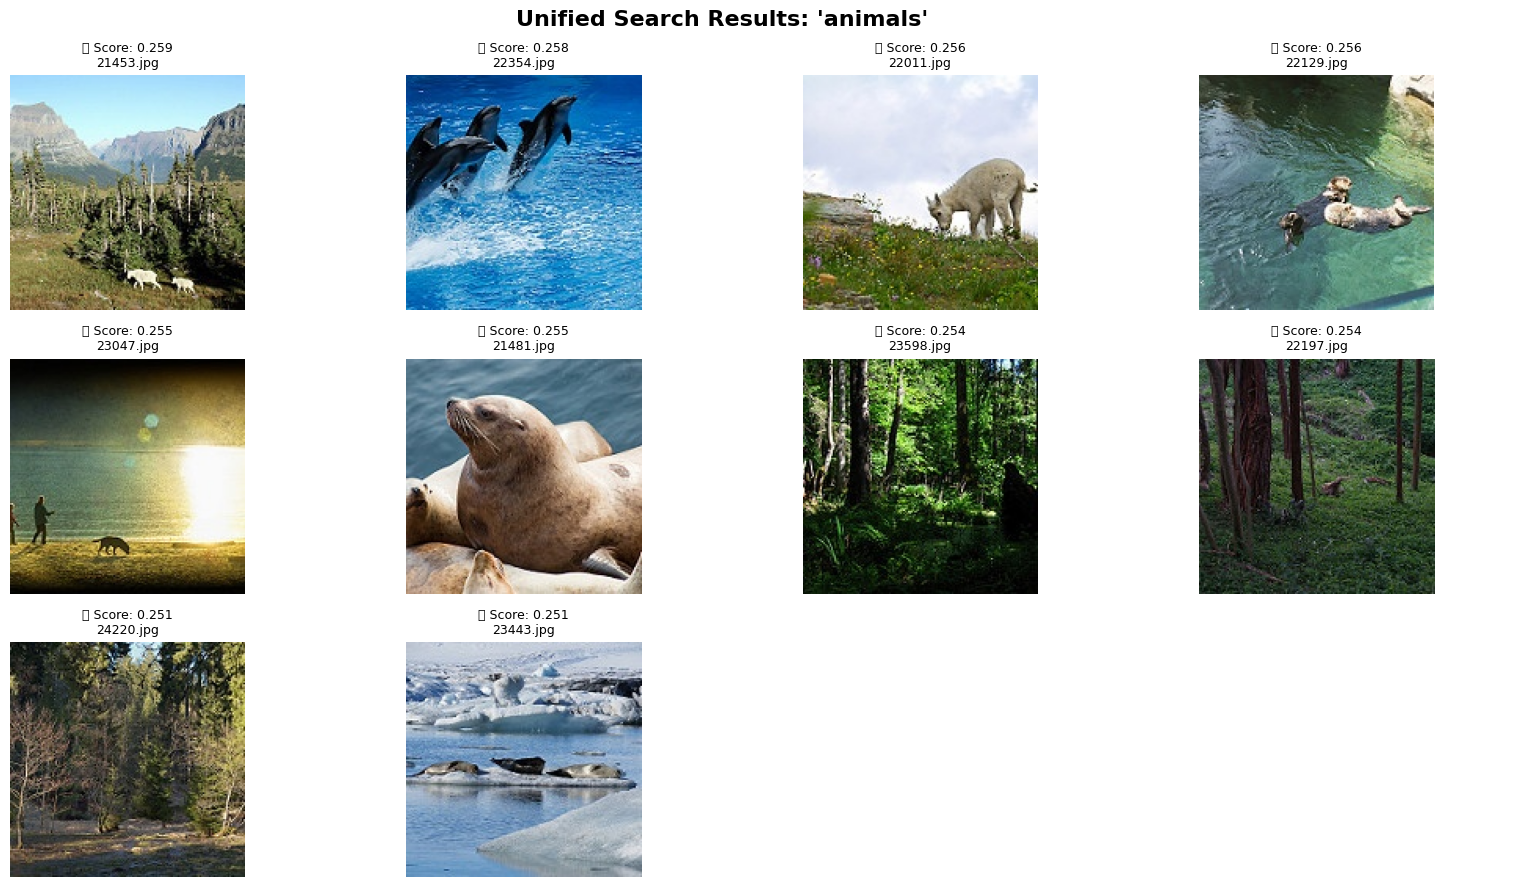


Top 10 results for 'animals' (images and videos mixed):
  1. [📷 IMAGE] 21453.jpg (similarity: 0.2590)
  2. [📷 IMAGE] 22354.jpg (similarity: 0.2577)
  3. [📷 IMAGE] 22011.jpg (similarity: 0.2565)
  4. [📷 IMAGE] 22129.jpg (similarity: 0.2560)
  5. [📷 IMAGE] 23047.jpg (similarity: 0.2548)
  6. [📷 IMAGE] 21481.jpg (similarity: 0.2545)
  7. [📷 IMAGE] 23598.jpg (similarity: 0.2541)
  8. [📷 IMAGE] 22197.jpg (similarity: 0.2536)
  9. [📷 IMAGE] 24220.jpg (similarity: 0.2514)
  10. [📷 IMAGE] 23443.jpg (similarity: 0.2506)


[(MediaSample(media_type=<MediaType.IMAGE: 'image'>, path=PosixPath('/Users/aban/drive/Projects/Automated-File-Allocator/notebooks/images/large_dataset/21453.jpg'), embedding=tensor([-3.8847e-02,  3.8774e-04, -2.1920e-03,  2.3342e-02,  1.7304e-02,
           6.5209e-03,  4.3780e-03, -2.1736e-02,  1.6819e-02,  5.6497e-02,
           4.9589e-03,  9.6125e-03,  5.7424e-03, -5.1427e-04,  3.6469e-02,
           2.4911e-02,  3.0998e-02,  9.3321e-04,  3.6935e-04,  5.2924e-02,
          -4.4066e-02,  4.0880e-02,  1.7608e-02, -8.2492e-02, -3.7975e-02,
           1.2137e-02,  3.4809e-02,  1.8185e-02,  1.2965e-02, -3.0796e-02,
          -4.1927e-03,  1.1748e-02,  1.4645e-02, -3.1155e-02, -2.8253e-02,
          -8.1739e-03,  4.2223e-02,  3.8610e-02, -8.4291e-03,  1.3774e-01,
          -1.6351e-02,  1.5172e-03, -5.1974e-03,  1.5670e-03,  3.4905e-02,
          -1.6151e-01,  2.8812e-02,  4.6310e-02, -1.1210e-02, -3.9459e-03,
           5.4233e-02,  3.3900e-03,  2.6874e-02, -8.5251e-03, -9.2033e-03,
  

In [9]:
def unified_semantic_search(
    query: str,
    clip_model: SentenceTransformer,
    embeddings: torch.Tensor,
    samples: Sequence[MediaSample],
    top_k: int = 10,
    device: str = DEVICE,
) -> List[Tuple[MediaSample, float]]:
    """Search across both images and videos using semantic similarity."""
    if not query.strip():
        raise ValueError("Query must be non-empty")
    
    query_embedding = clip_model.encode(
        query,
        convert_to_tensor=True,
        device=device,
        normalize_embeddings=True,
    )
    similarities = torch.matmul(query_embedding, embeddings.T).squeeze(0)
    top_indices = torch.topk(similarities, k=min(top_k, len(samples))).indices.cpu().tolist()
    return [(samples[idx], similarities[idx].item()) for idx in top_indices]


def display_unified_search_results(
    query: str,
    results: Sequence[Tuple[MediaSample, float]],
    max_display: int = 12,
) -> None:
    """Display search results showing both images and videos."""
    if not results:
        print(f"No results for query: '{query}'")
        return
    
    display_count = min(len(results), max_display)
    cols = 4
    rows = math.ceil(display_count / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)
    if cols == 1:
        axes = np.expand_dims(axes, axis=1)
    
    fig.suptitle(f"Unified Search Results: '{query}'", fontsize=16, fontweight="bold")
    
    for idx in range(display_count):
        row = idx // cols
        col = idx % cols
        ax = axes[row][col]
        ax.axis("off")
        sample, score = results[idx]
        try:
            thumbnail = sample.get_thumbnail()
            ax.imshow(thumbnail)
            media_type_label = "📷" if sample.media_type == MediaType.IMAGE else "🎬"
            ax.set_title(
                f"{media_type_label} Score: {score:.3f}\n{sample.path.name}",
                fontsize=9,
            )
        except Exception:
            ax.text(0.5, 0.5, "Error", ha="center", va="center")
    
    for idx in range(display_count, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row][col].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop {display_count} results for '{query}' (images and videos mixed):")
    for rank, (sample, score) in enumerate(results[:display_count], start=1):
        media_type_label = "📷 IMAGE" if sample.media_type == MediaType.IMAGE else "🎬 VIDEO"
        print(f"  {rank}. [{media_type_label}] {sample.path.name} (similarity: {score:.4f})")


def search_unified(query: str, top_k: int = 12) -> List[Tuple[MediaSample, float]]:
    """Convenience wrapper for unified semantic search."""
    results = unified_semantic_search(
        query=query,
        clip_model=model,
        embeddings=embeddings,
        samples=all_samples,
        top_k=top_k,
        device=DEVICE,
    )
    display_unified_search_results(query, results, max_display=top_k)
    return results


# Example: Search across both images and videos
search_unified("animals", top_k=10)


## Interoperability Summary

✅ **Yes, video and image embeddings are fully interoperable!**

### Why They Work Together:

1. **Same CLIP Model**: Both use `clip-ViT-B-32` → produces 512-dimensional embeddings
2. **Same Normalization**: Both use `normalize_embeddings=True` → embeddings are unit vectors
3. **Same Similarity Metric**: Cosine similarity works identically for both
4. **Unified Embedding Space**: Videos are represented by aggregated frame embeddings, but still live in the same semantic space as images

### Key Technical Details:

- **Image embeddings**: Direct CLIP encoding of the image → 512-d vector
- **Video embeddings**: Mean + attention-weighted pooling of frame embeddings → 512-d vector
- **Clustering**: Agglomerative clustering with cosine distance works on the combined embedding matrix
- **Search**: Text queries encode to the same 512-d space, enabling unified search

### Production Implications:

- **Single `/api/v1/search` endpoint** can return both images and videos ranked by similarity
- **Unified `asset` table** in PostgreSQL can store both media types with the same `embedding` column (vector(512))
- **Same pgvector index** works for both (HNSW index on `embedding` column)
- **Cluster assignment** can group semantically similar images and videos together

This enables the system to treat images and videos as first-class citizens in the same semantic search and clustering pipeline!
